#[TensorFlow Hub Object Detection Colab](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb#scrollTo=rOvvWAVTkMR7)

<h1><center>Tensorflow Hub object_detection</h1>

<center> [Source](https://tfhub.dev/tensorflow/collections/object_detection/1) </center>

| Model name | Speed (ms) | COCO mAP |
| --- | --- | --- |
| [CenterNet HourGlass104 512x512](https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1) | 70 | 	41.9 | 
| [EfficientDet D2 768x768](https://tfhub.dev/tensorflow/efficientdet/d2/1) | 67 | 41.8 |
| [EfficientDet D3 896x896](https://tfhub.dev/tensorflow/efficientdet/d3/1) | 95 | 45.4 |
| [SSD ResNet101 V1 FPN 640x640 (RetinaNet101)](https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1) | 57 | 35.6 |
| [CenterNet Resnet101 V1 FPN 512x512](https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1) | 34 | 34.2 |
| [CenterNet Resnet50 V1 FPN 512x512](https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1)	| 27	| 31.2 |

### Install tensorflow

In [ ]:
# This Colab requires TF 2.5.
!pip install -U "tensorflow>=2.5"

     |████████████████████████████████| 462 kB 5.1 MB/s 


### Import all the requirements 

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

### Connect to get Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Change directory

In [ ]:
%cd /content/drive/MyDrive/Tensorflow2

/content/drive/MyDrive/Tensorflow2


### Clone Tensorflow Models

In [ ]:
# Clone the tensorflow models repository
#!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3328, done.
remote: Counting objects: 100% (3328/3328), done.
remote: Compressing objects: 100% (2753/2753), done.
remote: Total 3328 (delta 883), reused 1402 (delta 525), pack-reused 0
Receiving objects: 100% (3328/3328), 34.30 MiB | 10.14 MiB/s, done.
Resolving deltas: 100% (883/883), done.
Checking out files: 100% (3025/3025), done.


### Intalling the Object Detection API

In [ ]:
!sudo apt install -y protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
%cd /content/drive/MyDrive/Tensorflow2/models/research/

/content/drive/MyDrive/Tensorflow2/models/research


In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!cp /content/drive/MyDrive/Tensorflow2/models/research/object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

Processing /content/drive/MyDrive/Tensorflow2/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.2 MB 8.3 MB/s 
     |████████████████████████████████| 352 kB 53.8 MB/s 
     |████████████████████████████████| 2.2 MB 36.4 MB/s 
     |████████████████████████████████| 23.4 MB 1.5 MB/s 
     |████████████████████████████████| 99 kB 9.6 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 37.0 MB/s 
     |████████████████████████████████| 90 kB 10.4 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |███████████████████

### import the dependencies

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

###Load label map data

In [ ]:
PATH_TO_LABELS = '/content/drive/MyDrive/Tensorflow2/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
# model_display_name = 'CenterNet HourGlass104 512x512'
# model_handle = 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1'
model_display_name = 'EfficientDet D3 896x896'
model_handle = 'https://tfhub.dev/tensorflow/efficientdet/d3/1'

In [ ]:
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

In [ ]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'EfficientDet D3 896x896' # @param ['CenterNet HourGlass104 512x512','EfficientDet D3 896x896']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

###Function to load image as numpy array

In [ ]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


### Selected Model

In [ ]:
print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:EfficientDet D3 896x896
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/efficientdet/d3/1


###Load the selected model

In [ ]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...


model loaded!


####Standard human pose keypoints input required, but not for our purpose

In [ ]:
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

### Image paths

In [ ]:
IMAGES_FOR_TEST = {
    'Beach' : '/content/drive/MyDrive/Tensorflow2/models/research/object_detection/test_images/image2.jpg',
  'femaleconnector-0' : '/content/drive/MyDrive/Tensorflow/dataset/images/femaleconnector-0.jpg',
  'femaleconnector-46' : '/content/drive/MyDrive/Tensorflow/dataset/images/femaleconnector-46.jpg',
  'femaleconnector-60' : '/content/drive/MyDrive/Tensorflow/dataset/images/femaleconnector-60.jpg',
  'femaleconnector-73' : '/content/drive/MyDrive/Tensorflow/dataset/images/femaleconnector-73.jpg',
  'femaleconnector-82' : '/content/drive/MyDrive/Tensorflow/dataset/images/femaleconnector-82.jpg',
  'femaleconnector-91' : '/content/drive/MyDrive/Tensorflow/dataset/images/femaleconnector-91.jpg',
  'femaleconnector-123' : '/content/drive/MyDrive/Tensorflow/dataset/images/femaleconnector-123.jpg',
}

###Select the image to be fed into the model

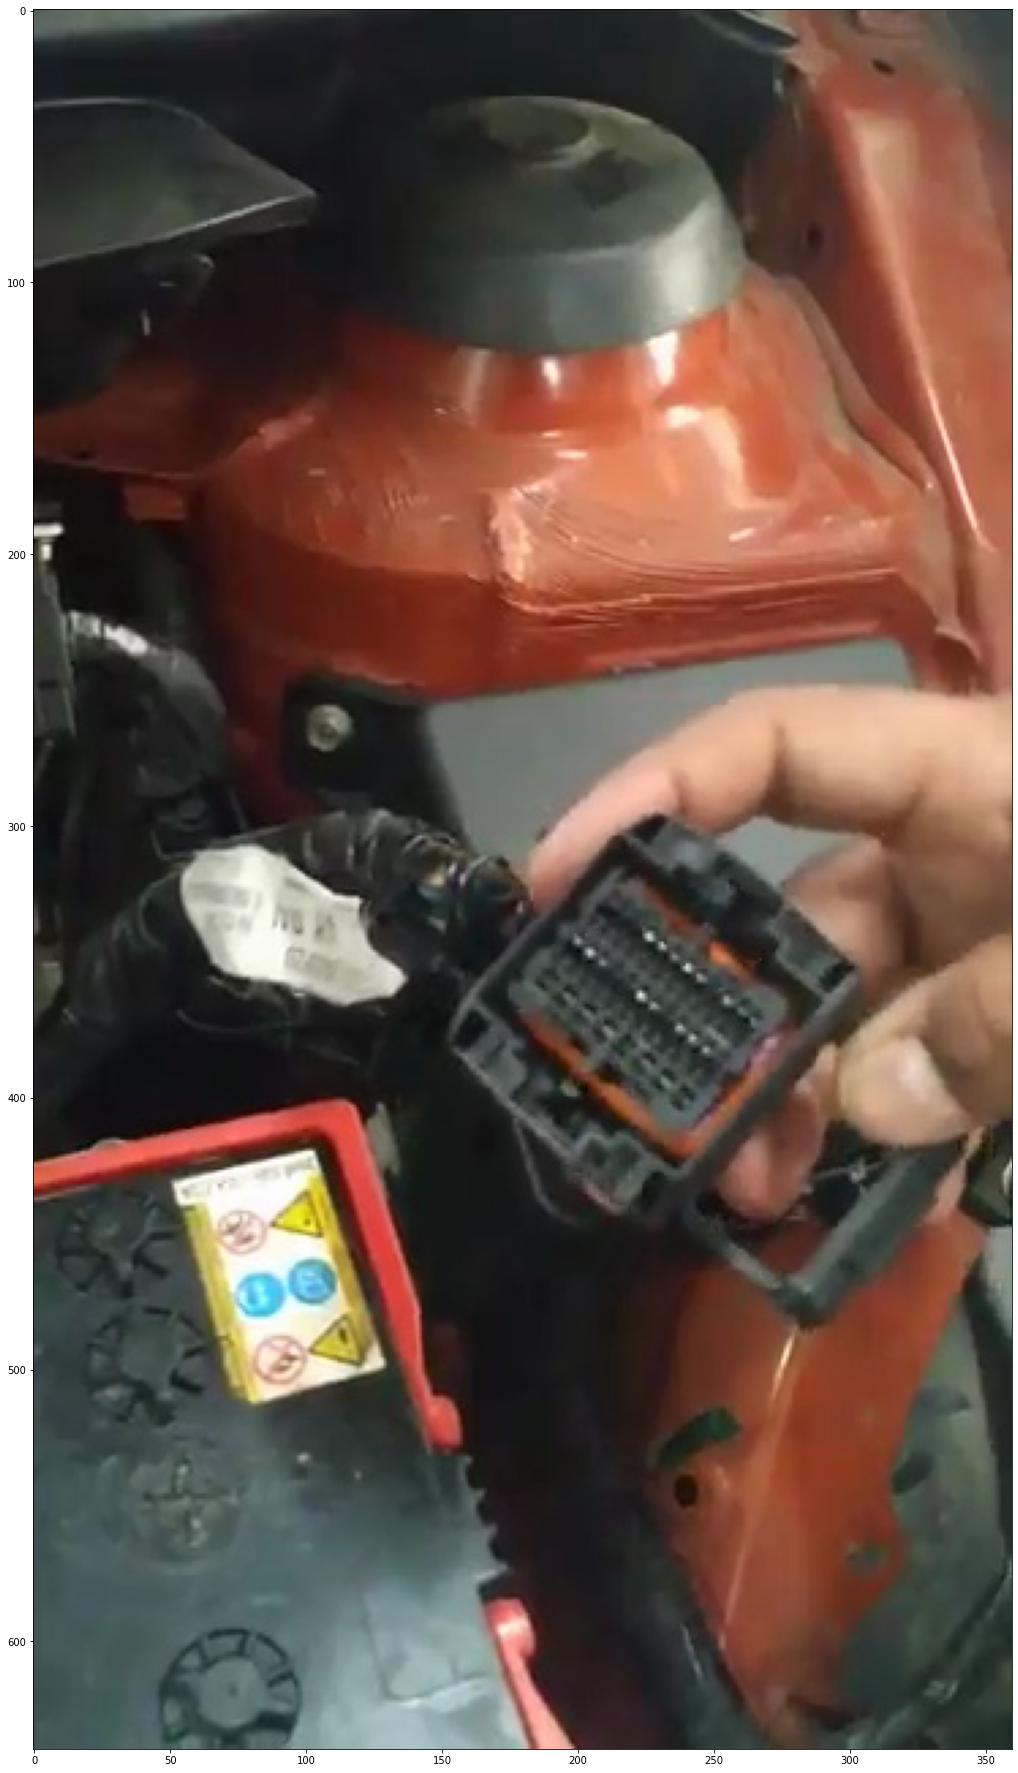

In [ ]:
selected_image = 'femaleconnector-0' # @param ['Beach','femaleconnector-0', 'femaleconnector-46', 'femaleconnector-60', 'femaleconnector-73', 'femaleconnector-82', 'femaleconnector-91','femaleconnector-123']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

###Running inference

In [ ]:
print(image_np.shape)
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

(1, 640, 360, 3)
dict_keys(['num_detections', 'detection_multiclass_scores', 'detection_scores', 'raw_detection_scores', 'raw_detection_boxes', 'detection_anchor_indices', 'detection_boxes', 'detection_classes'])


### Required to save the image on Google Drive

In [ ]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 71.0 MB/s 


### Plot the detecions and save the image in the hardcoded location

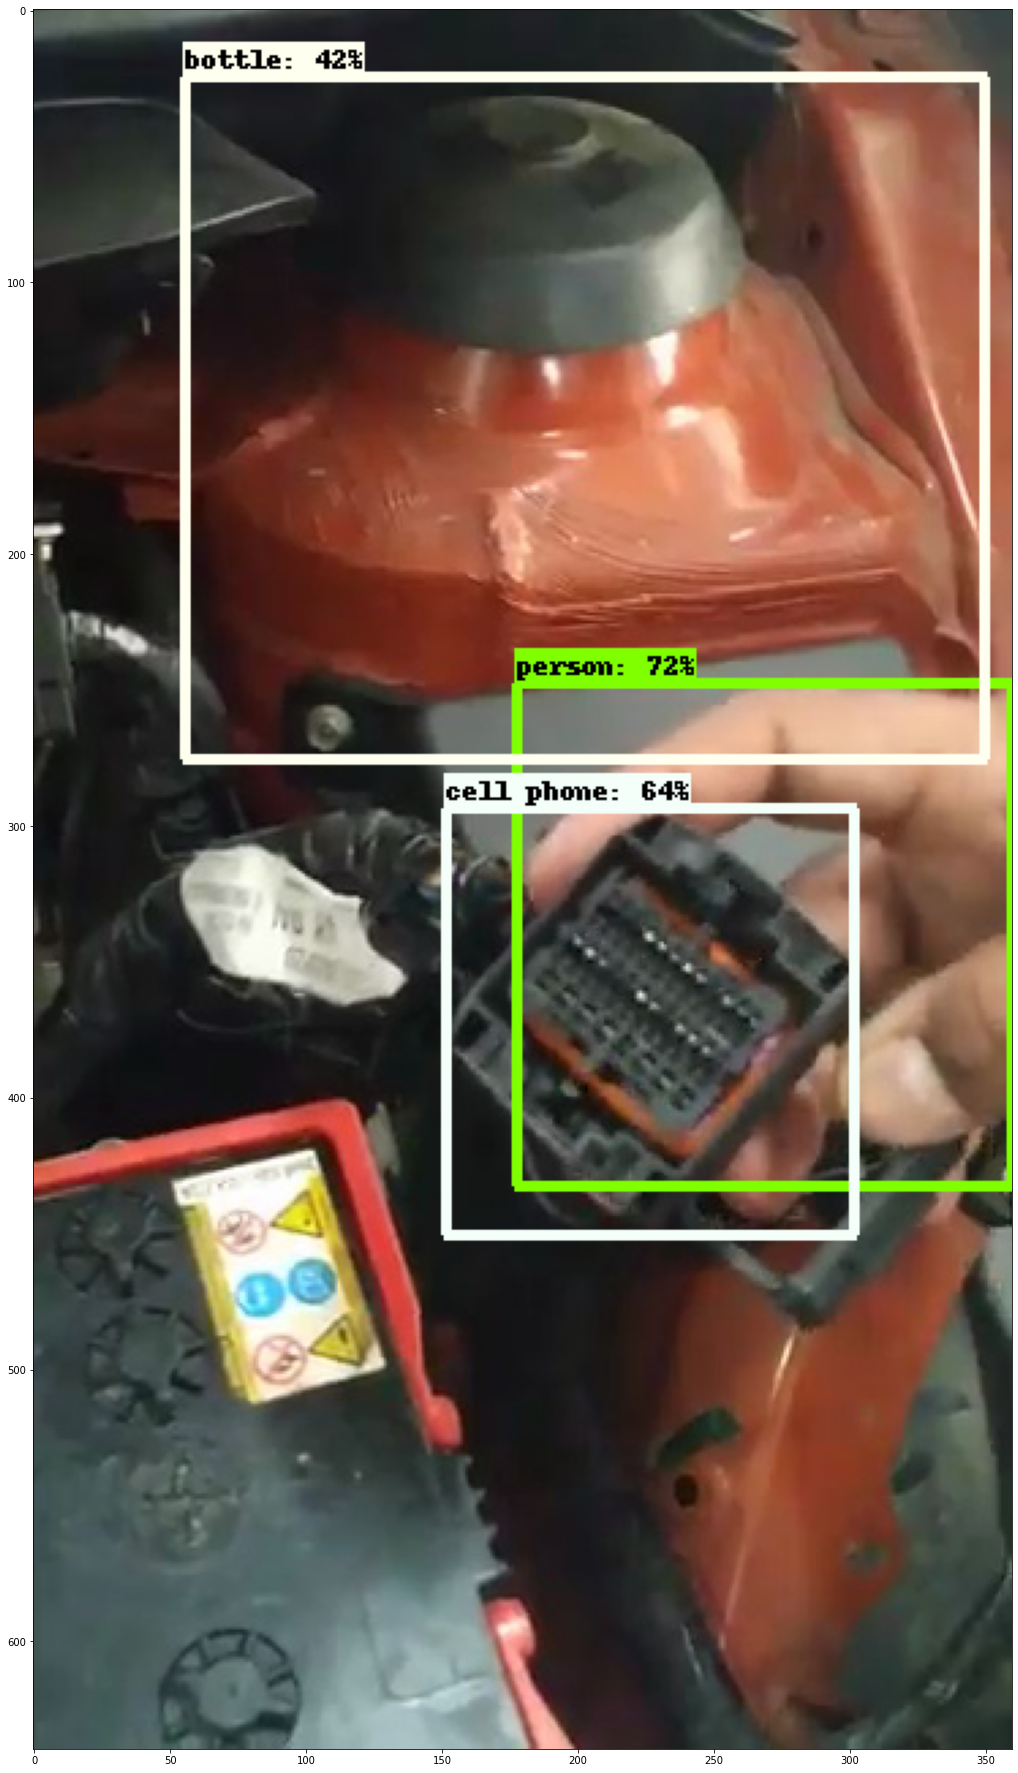

In [ ]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.33,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)
# hard code the image path to be save after inference
image_save_path = "/content/drive/MyDrive/Tensorflow2/Results/femaleconnector-0-efficientdet.jpg"
import cv2
cv2.imwrite(image_save_path, cv2.cvtColor(image_np_with_detections[0], cv2.COLOR_BGR2RGB))
plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()